# 1. Set up environment

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [90]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [91]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.5.1-bin-hadoop3'

In [92]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("featureClass")\
        .getOrCreate()

# 2. Input data

## 2.1. Table of 1000 samples with full feature

In [93]:
path = '/content/drive/MyDrive/University/Academic/IU/SEM 6/Big Data Analytics for Remote Sensing Laboratory/Final project/Feature extraction/'
name1 = 'mini_gz2_info_update.csv'
data_gz2_f1 = spark.read.csv(path+name1, header=True)

In [94]:
data_gz2_f1.show(5)

+--------+------+-----------+-------------+------------------+------------------+----------+----------+
|FileName|K_Area|K_Perimeter|K_Orientation|    K_Eccentricity|        K_Solidity|Num_bright|Num_center|
+--------+------+-----------+-------------+------------------+------------------+----------+----------+
|  198489|     3|          3|            0| 0.816496580927726|               1.0|         1|         1|
|  115111|  5723|        323|            0|0.8812674980194473|0.9709874448591789|         1|         1|
|  217599|  4187|        285|            1|0.8351878647416635|0.9318940574226575|         1|         1|
|  248585|  5658|        328|            0|0.7106350214678104|0.9415876185721418|         1|         1|
|   63958|  4820|        292|            0|0.7910775518894992|0.9563492063492064|         1|         1|
+--------+------+-----------+-------------+------------------+------------------+----------+----------+
only showing top 5 rows



In [95]:
data_gz2_f1.printSchema()

root
 |-- FileName: string (nullable = true)
 |-- K_Area: string (nullable = true)
 |-- K_Perimeter: string (nullable = true)
 |-- K_Orientation: string (nullable = true)
 |-- K_Eccentricity: string (nullable = true)
 |-- K_Solidity: string (nullable = true)
 |-- Num_bright: string (nullable = true)
 |-- Num_center: string (nullable = true)



In [96]:
data_gz2_f1.count()

1000

## 2.2. Table of full samples with inital primary features

In [97]:
name2 = 'full_gz2_info.csv'
data_gz2_f2 = spark.read.csv(path+name2, header=True)

In [98]:
data_gz2_f2.count()

243434

In [99]:
data_gz2_f2.show(5)

+--------+----+---------+-----------+------------------+------------------+
|FileName|Area|Perimeter|Orientation|      Eccentricity|          Solidity|
+--------+----+---------+-----------+------------------+------------------+
|   64601| 102|       37|          0|0.6841466926899771|0.8095238095238095|
|   31973|  95|       36|          0|0.7010880648048295|0.9223300970873787|
|  168202| 120|       41|          0| 0.682538394857283|0.9302325581395349|
|  125778|   2|        0|          0|               1.0|               1.0|
|   99807|  71|       33|          0|0.9149714344835805| 0.922077922077922|
+--------+----+---------+-----------+------------------+------------------+
only showing top 5 rows



In [100]:
data_gz2_f2.printSchema()

root
 |-- FileName: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Perimeter: string (nullable = true)
 |-- Orientation: string (nullable = true)
 |-- Eccentricity: string (nullable = true)
 |-- Solidity: string (nullable = true)



## 2.3. Mapping table

In [101]:
name3 = 'mini_1000s_7c_gz2_hart16_mapping.csv'
map_gz2 = spark.read.csv(path+name3, header=True)

In [102]:
map_gz2 = map_gz2.select('dr7objid', 'asset_id', 'gz2_class')

In [103]:
map_gz2.count()

1000

In [104]:
map_gz2.show(5)

+------------------+--------+---------+
|          dr7objid|asset_id|gz2_class|
+------------------+--------+---------+
|588010879833997510|  198489|       Ei|
|587738946673639494|  115111|       Ei|
|588017703489241485|  217599|       Ei|
|587728880341876898|  248585|       Ei|
|587733079742283987|   63958|       Ei|
+------------------+--------+---------+
only showing top 5 rows



# 3. Data Pre-processing

## 3.1. Join tables

### 3.1.1. Join 2 feature tables

In [105]:
joined_feature = data_gz2_f1.join(data_gz2_f2, on='FileName', how='inner')

In [106]:
joined_feature.count()

1000

In [107]:
joined_feature.show(5)

+--------+------+-----------+-------------+------------------+------------------+----------+----------+----+---------+-----------+------------------+------------------+
|FileName|K_Area|K_Perimeter|K_Orientation|    K_Eccentricity|        K_Solidity|Num_bright|Num_center|Area|Perimeter|Orientation|      Eccentricity|          Solidity|
+--------+------+-----------+-------------+------------------+------------------+----------+----------+----+---------+-----------+------------------+------------------+
|  103494|    14|         11|            1|0.5807496412612706|0.9333333333333333|         1|         1|  61|       28|          0|0.4663801562932721|0.8970588235294118|
|  149762|  5005|        353|            0|0.8484307944167624|0.8915211970074813|         1|         1| 107|       39|          0|0.8201995885620832|0.9385964912280702|
|  223036|  5426|        359|            0|0.7844387700778765|0.9136218218555312|         1|         1| 160|       55|          0|0.9016010785220842|0.8421

### 3.1.2. Join feature table with mapping table

In [108]:
df_gz2 = joined_feature.join(map_gz2, joined_feature.FileName == map_gz2.asset_id, "inner")
df_gz2 = df_gz2.drop('asset_id')

In [109]:
df_gz2.count()

1000

In [110]:
df_gz2.show(5)

+--------+------+-----------+-------------+------------------+------------------+----------+----------+----+---------+-----------+------------------+------------------+------------------+---------+
|FileName|K_Area|K_Perimeter|K_Orientation|    K_Eccentricity|        K_Solidity|Num_bright|Num_center|Area|Perimeter|Orientation|      Eccentricity|          Solidity|          dr7objid|gz2_class|
+--------+------+-----------+-------------+------------------+------------------+----------+----------+----+---------+-----------+------------------+------------------+------------------+---------+
|  103494|    14|         11|            1|0.5807496412612706|0.9333333333333333|         1|         1|  61|       28|          0|0.4663801562932721|0.8970588235294118|587736976345596190|     Sc2t|
|  149762|  5005|        353|            0|0.8484307944167624|0.8915211970074813|         1|         1| 107|       39|          0|0.8201995885620832|0.9385964912280702|587741489301880939|    SBc2l|
|  223036|

### 3.1.3. Export to cvs file (optional)

In [111]:
'''# Convert to panda df
pd_gz2 = df_gz2.toPandas()
# Export to csv
name_out = 'final_gz2.csv'
pd_gz2.to_csv(path+name_out, header=True, index=False)'''

"# Convert to panda df\npd_gz2 = df_gz2.toPandas()\n# Export to csv\nname_out = 'final_gz2.csv'\npd_gz2.to_csv(path+name_out, header=True, index=False)"

### 3.2. Group 7 classes to 5 classes for equality

In [112]:
from pyspark.sql import functions as F

In [113]:
df_gz2.groupBy('gz2_class').count().show()

+---------+-----+
|gz2_class|count|
+---------+-----+
|      Ser|  200|
|    SBc2l|  200|
|     Sc2t|  100|
|        m|  200|
|       Er|  100|
|       Ei|  100|
|     Sc3t|  100|
+---------+-----+



In [114]:
# Combine classes
df_gz2 = df_gz2.withColumn("gz2_class",
                           F.when(df_gz2.gz2_class == "Ei", "E")
                           .when(df_gz2.gz2_class == "Er", "E")
                           .when(df_gz2.gz2_class == "Sc2t", "Sc")
                           .when(df_gz2.gz2_class == "Sc3t", "Sc")
                           .otherwise(df_gz2.gz2_class))

In [115]:
df_gz2.groupBy('gz2_class').count().show()

+---------+-----+
|gz2_class|count|
+---------+-----+
|      Ser|  200|
|    SBc2l|  200|
|        m|  200|
|        E|  200|
|       Sc|  200|
+---------+-----+



## 3.2. Prepare table for classification

### 3.2.1. Convert measurements to Double

In [116]:
# Convert all attributes (beside FileName, dr7objid and gz2_class) to double
for col in df_gz2.columns:
  if col not in ("FileName", "dr7objid", "gz2_class"):
    df_gz2 = df_gz2.withColumn(col, F.col(col).cast("double"))

In [117]:
df_gz2.dtypes

[('FileName', 'string'),
 ('K_Area', 'double'),
 ('K_Perimeter', 'double'),
 ('K_Orientation', 'double'),
 ('K_Eccentricity', 'double'),
 ('K_Solidity', 'double'),
 ('Num_bright', 'double'),
 ('Num_center', 'double'),
 ('Area', 'double'),
 ('Perimeter', 'double'),
 ('Orientation', 'double'),
 ('Eccentricity', 'double'),
 ('Solidity', 'double'),
 ('dr7objid', 'string'),
 ('gz2_class', 'string')]

In [118]:
df_gz2.drop('FileName', 'dr7objid', 'gz2_class').describe().show()

+-------+------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+----------------+------------------+-------------------+------------------+-------------------+
|summary|            K_Area|       K_Perimeter|     K_Orientation|     K_Eccentricity|         K_Solidity|       Num_bright|         Num_center|            Area|         Perimeter|        Orientation|      Eccentricity|           Solidity|
+-------+------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+----------------+------------------+-------------------+------------------+-------------------+
|  count|              1000|              1000|              1000|               1000|               1000|             1000|               1000|            1000|              1000|               1000|              1000|               1000|
|   mean|          3923.682|           2

### 3.2.2. Convert negative values to positive

In [119]:
# Negative value in Orientation is a reflection of the same Positive value image
df_gz2 = df_gz2.withColumn("Orientation", F.abs(F.col("Orientation")))
df_gz2 = df_gz2.withColumn("K_Orientation", F.abs(F.col("K_Orientation")))

In [120]:
df_gz2.drop('FileName', 'dr7objid', 'gz2_class').describe().show()

+-------+------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+----------------+------------------+------------------+------------------+-------------------+
|summary|            K_Area|       K_Perimeter|     K_Orientation|     K_Eccentricity|         K_Solidity|       Num_bright|         Num_center|            Area|         Perimeter|       Orientation|      Eccentricity|           Solidity|
+-------+------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+----------------+------------------+------------------+------------------+-------------------+
|  count|              1000|              1000|              1000|               1000|               1000|             1000|               1000|            1000|              1000|              1000|              1000|               1000|
|   mean|          3923.682|           282.4

### 3.2.3. Check NULL values

In [121]:
from pyspark.sql.functions import col,isnan, when, count

In [122]:
df_gz2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_gz2.columns]).show()
df_gz2.count()

+--------+------+-----------+-------------+--------------+----------+----------+----------+----+---------+-----------+------------+--------+--------+---------+
|FileName|K_Area|K_Perimeter|K_Orientation|K_Eccentricity|K_Solidity|Num_bright|Num_center|Area|Perimeter|Orientation|Eccentricity|Solidity|dr7objid|gz2_class|
+--------+------+-----------+-------------+--------------+----------+----------+----------+----+---------+-----------+------------+--------+--------+---------+
|       0|     0|          0|            0|             0|         0|         0|         0|   0|        0|          0|           0|       0|       0|        0|
+--------+------+-----------+-------------+--------------+----------+----------+----------+----+---------+-----------+------------+--------+--------+---------+



1000

### 3.2.4. Feature transformation

In [123]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [124]:
from pyspark.ml.feature import VectorAssembler
import numpy as np

In [125]:
from pyspark.ml.feature import StandardScaler

In [126]:
def feature_transformation(df, drop_feature=[]):
  # Index label
  stringindexer = StringIndexer(inputCol='gz2_class', outputCol='label')
  stages = [stringindexer]

  #Build pipeline and transform data
  pipeline = Pipeline(stages=stages)
  df_features1 = pipeline.fit(df).transform(df)

  # Create vector feature
  assembler = VectorAssembler(inputCols=[col for col in df_features1.columns if col not in drop_feature], outputCol="features")
  stages = [assembler]

  #Build pipeline and transform data
  pipeline = Pipeline(stages=stages)
  df_features2 = pipeline.fit(df_features1).transform(df_features1)

  # Normalize feature vector
  scaler = StandardScaler(inputCol="features", outputCol="normFeatures", withStd=True, withMean=False)
  scalerModel = scaler.fit(df_features2)
  df_scaled = scalerModel.transform(df_features2)

  return df_scaled

### 3.2.5. Feature selection (Correlation)

#### 3.2.5.1. First inspection

In [127]:
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# Create normalized feature vector including the label for correlation check
df_cor = feature_transformation(df_gz2, drop_feature=['gz2_class', 'FileName', 'dr7objid'])
df_cor.show(5)

+--------+------+-----------+-------------+------------------+------------------+----------+----------+-----+---------+-----------+------------------+------------------+------------------+---------+-----+--------------------+--------------------+
|FileName|K_Area|K_Perimeter|K_Orientation|    K_Eccentricity|        K_Solidity|Num_bright|Num_center| Area|Perimeter|Orientation|      Eccentricity|          Solidity|          dr7objid|gz2_class|label|            features|        normFeatures|
+--------+------+-----------+-------------+------------------+------------------+----------+----------+-----+---------+-----------+------------------+------------------+------------------+---------+-----+--------------------+--------------------+
|  103494|  14.0|       11.0|          1.0|0.5807496412612706|0.9333333333333333|       1.0|       1.0| 61.0|     28.0|        0.0|0.4663801562932721|0.8970588235294118|587736976345596190|       Sc|  2.0|[14.0,11.0,1.0,0....|[0.00703009189185...|
|  149762|50

In [129]:
df_cor.select(['label','features','normFeatures']).show(5, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                 |normFeatures                                                                                                                                                                                                                             |
+-----+-------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------

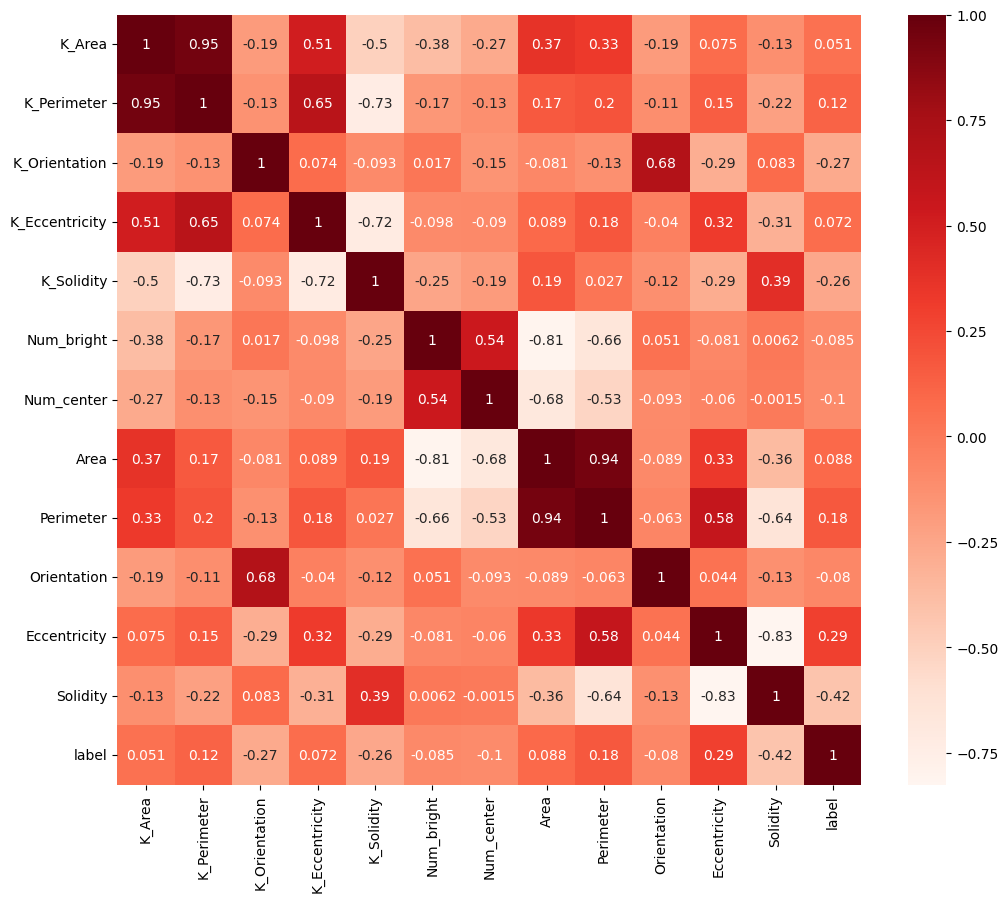

In [130]:
# Get correlation matrix
matrix = Correlation.corr(df_cor.select('normFeatures'), 'normFeatures').collect()[0][0]

# Convert matrix to array
corr_matrix = matrix.toArray().tolist()

# Convert to panda df
drop_col = ['FileName', 'gz2_class', 'features', 'normfeatures', 'dr7objid']
df_pandas = df_cor.drop(*drop_col).toPandas()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_pandas.columns, index = df_pandas.columns)

# Plot the correlation analysis
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_df.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

#### 3.2.5.2. Second inspection

In [131]:
# Drop less-attributing columns to label and high-attributing columns to each other
drop_at = ['K_Area', 'Area', 'K_Perimeter', 'K_Orientation', 'K_Eccentricity', 'Solidity']
df_gz2_2 = df_gz2.drop(*drop_at)

# Create normalized feature vector including the label for correlation check
df_cor2 = feature_transformation(df_gz2_2, drop_feature=['gz2_class', 'FileName', 'dr7objid'])
df_cor2.show(5)

+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+
|FileName|        K_Solidity|Num_bright|Num_center|Perimeter|Orientation|      Eccentricity|          dr7objid|gz2_class|label|            features|        normFeatures|
+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+
|  103494|0.9333333333333333|       1.0|       1.0|     28.0|        0.0|0.4663801562932721|587736976345596190|       Sc|  2.0|[0.93333333333333...|[19.6906119479676...|
|  149762|0.8915211970074813|       1.0|       1.0|     39.0|        0.0|0.8201995885620832|587741489301880939|    SBc2l|  1.0|[0.89152119700748...|[18.8084977860663...|
|  223036|0.9136218218555312|       1.0|       1.0|     55.0|        0.0|0.9016010785220842|588017728152338604|        m|  4.0|[0.91362182185553...|[1

In [132]:
df_cor2.select(['label','features','normFeatures']).show(5, truncate=False)

+-----+------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                    |normFeatures                                                                                                                       |
+-----+------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|2.0  |[0.9333333333333333,1.0,1.0,28.0,0.0,0.4663801562932721,2.0]|[19.690611947967668,5.142573500734494,11.988341336913885,1.5759220601996817,0.0,1.757023016355068,1.4135062787267691]              |
|1.0  |[0.8915211970074813,1.0,1.0,39.0,0.0,0.8201995885620832,1.0]|[18.808497786066372,5.142573500734494,11.988341336913885,2.195034298135271,0.0,3.08998900502604,0.7067531393633846]             

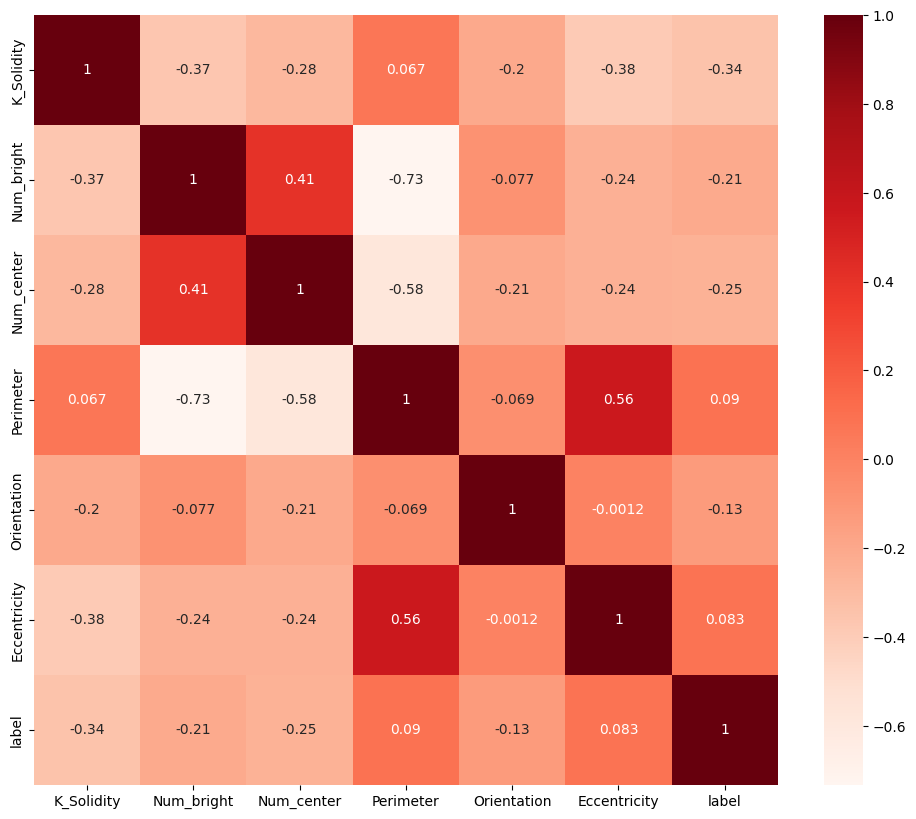

In [133]:
# Get correlation matrix
matrix = Correlation.corr(df_cor2.select('normFeatures'), 'normFeatures').collect()[0][0]

# Convert matrix to array
corr_matrix = matrix.toArray().tolist()

# Convert to panda df
drop_col = ['FileName', 'gz2_class', 'features', 'normfeatures', 'dr7objid']
df_pandas = df_cor2.drop(*drop_col).toPandas()
corr_matrix_df2 = pd.DataFrame(data=corr_matrix, columns = df_pandas.columns, index = df_pandas.columns)

# Plot the correlation analysis
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_df2.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

#### 3.2.5.3 Extract table for classification

In [134]:
# Create normalized feature vector including the label for correlation check
df_feature = feature_transformation(df_gz2_2, drop_feature=['gz2_class', 'FileName', 'dr7objid', 'label'])
df_feature.show(5)

+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+
|FileName|        K_Solidity|Num_bright|Num_center|Perimeter|Orientation|      Eccentricity|          dr7objid|gz2_class|label|            features|        normFeatures|
+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+
|  103494|0.9333333333333333|       1.0|       1.0|     28.0|        0.0|0.4663801562932721|587736976345596190|       Sc|  2.0|[0.93333333333333...|[19.6906119479676...|
|  149762|0.8915211970074813|       1.0|       1.0|     39.0|        0.0|0.8201995885620832|587741489301880939|    SBc2l|  1.0|[0.89152119700748...|[18.8084977860663...|
|  223036|0.9136218218555312|       1.0|       1.0|     55.0|        0.0|0.9016010785220842|588017728152338604|        m|  4.0|[0.91362182185553...|[1

In [135]:
df_feature.select(['label','features','normFeatures']).show(5, truncate=False)

+-----+--------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+
|label|features                                                |normFeatures                                                                                                    |
+-----+--------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+
|2.0  |[0.9333333333333333,1.0,1.0,28.0,0.0,0.4663801562932721]|[19.690611947967668,5.142573500734494,11.988341336913885,1.5759220601996817,0.0,1.757023016355068]              |
|1.0  |[0.8915211970074813,1.0,1.0,39.0,0.0,0.8201995885620832]|[18.808497786066372,5.142573500734494,11.988341336913885,2.195034298135271,0.0,3.08998900502604]                |
|4.0  |[0.9136218218555312,1.0,1.0,55.0,0.0,0.9016010785220842]|[19.274756530020547,5.142573500734494,11.98834

In [136]:
# Find classes and their corresponding labels with count
df_feature.groupby('gz2_class', 'label').agg(count('*').alias('count')).sort('label', ascending=True).show()

+---------+-----+-----+
|gz2_class|label|count|
+---------+-----+-----+
|        E|  0.0|  200|
|    SBc2l|  1.0|  200|
|       Sc|  2.0|  200|
|      Ser|  3.0|  200|
|        m|  4.0|  200|
+---------+-----+-----+



# 4. Classification

In [137]:
# Randomly split data into training and test sets. set seed for reproducibility
train, test = df_feature.randomSplit([0.8, 0.2], seed=1234)

## 4.1. NAIVE BAYES Classification

In [138]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

In [139]:
# Build Naive Bayes classification model
# (Naive Bayes model does not accept negative values in the input vector)
naivebayes = NaiveBayes(featuresCol="normFeatures", labelCol="label")

In [140]:
# Parameter grid
param_grid = ParamGridBuilder().addGrid(naivebayes.smoothing, [0, 1, 2, 4, 8]).build()

### 4.1.1. Training

In [141]:
# Evaluator
evaluator = MulticlassClassificationEvaluator()

# Build cross-validation model
crossvalidator = CrossValidator(estimator=naivebayes, estimatorParamMaps=param_grid, evaluator=evaluator)

# Fit cross-validation model
crossvalidation_mode = crossvalidator.fit(train)

### 4.1.2. Prediction

In [142]:
# Prediction on training sets
pred_train = crossvalidation_mode.transform(train)
pred_train.show(5)

+--------+------------------+----------+----------+---------+-----------+-------------------+------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|FileName|        K_Solidity|Num_bright|Num_center|Perimeter|Orientation|       Eccentricity|          dr7objid|gz2_class|label|            features|        normFeatures|       rawPrediction|         probability|prediction|
+--------+------------------+----------+----------+---------+-----------+-------------------+------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    1002|0.9514612886686037|       1.0|       1.0|     36.0|        0.0| 0.6154641046567995|587722983355514966|       Sc|  2.0|[0.95146128866860...|[20.0730589485929...|[-55.294425033537...|[0.19960138347050...|       2.0|
|  100667|0.9537953795379538|       0.0|       1.0|     46.0|        0.0| 0.6743576277534353|58773691674

In [143]:
# Prediction on test sets
pred_test = crossvalidation_mode.transform(test)
pred_test.show(5)

+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|FileName|        K_Solidity|Num_bright|Num_center|Perimeter|Orientation|      Eccentricity|          dr7objid|gz2_class|label|            features|        normFeatures|       rawPrediction|         probability|prediction|
+--------+------------------+----------+----------+---------+-----------+------------------+------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  100201|0.9735346889952153|       0.0|       1.0|     65.0|        0.0|0.9119488634696645|587736915149324848|      Ser|  3.0|[0.97353468899521...|[20.5387433345251...|[-52.884574372843...|[0.19287826850606...|       3.0|
|  101141|0.9336704921221552|       1.0|       1.0|     35.0|        0.0|0.8440794779549687|5877369199751989

### 4.1.3. Evaluation

In [144]:
from sklearn.metrics import confusion_matrix

In [145]:
#Best model from cross validation
print("The parameter smoothing has best value:", crossvalidation_mode.bestModel._java_obj.getSmoothing())

The parameter smoothing has best value: 0.0


training data (f1): 0.3076692849261339 
 training data (weightedPrecision):  0.28644116169479844 
 training data (weightedRecall):  0.34668335419274093 
 training data (accuracy):  0.34668335419274093


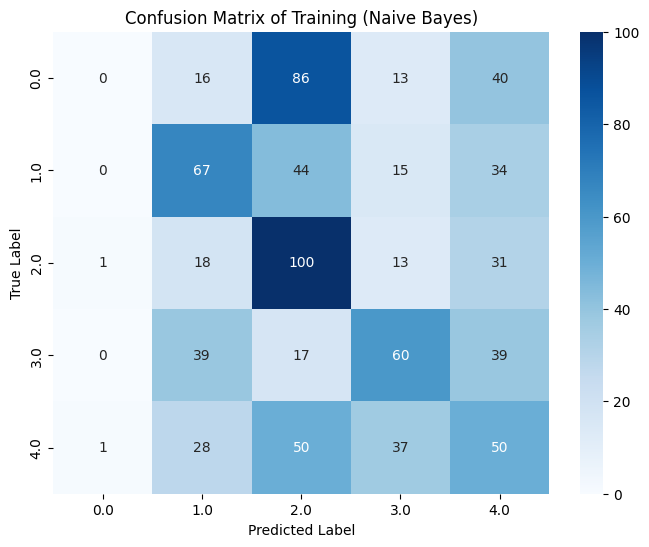

In [146]:
#Prediction accuracy on training data
print('training data (f1):', evaluator.setMetricName('f1').evaluate(pred_train), "\n",
     'training data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_train),"\n",
     'training data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_train),"\n",
     'training data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_train))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_train.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Training (Naive Bayes)")
plt.show()

test data (f1): 0.2523789550160814 
 test data (weightedPrecision):  0.2350532844003727 
 test data (weightedRecall):  0.2835820895522388 
 test data (accuracy):  0.2835820895522388


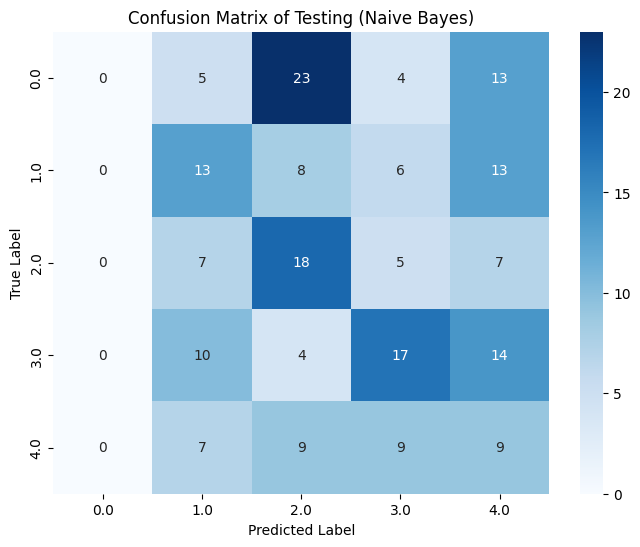

In [147]:
#Prediction accuracy on test data
print('test data (f1):', evaluator.setMetricName('f1').evaluate(pred_test), "\n",
     'test data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_test),"\n",
     'test data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_test),"\n",
     'test data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_test))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_test.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Testing (Naive Bayes)")
plt.show()

## 4.2. K-Nearest Neighbors Classification

Because KNearestNeighbor classification algorithm is not available in pyspark.ml.classification library, we use Scikit learn library instead

### 4.2.1. Training

In [148]:
from sklearn.neighbors import KNeighborsClassifier

In [149]:
# Split labels and features to arrays
train_label = np.array(train.select('label').collect()).reshape(-1)
train_features = np.array([x[0] for x in train.select('normFeatures').collect()])
test_label = np.array(test.select('label').collect()).reshape(-1)
test_features = np.array([x[0] for x in test.select('normFeatures').collect()])

In [150]:
# Initiate K neighbors = 16
neighbors = np.arange(1,16)

# Initiate arrays to store accuracies
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model with Training data
    knn.fit(train_features, train_label)

    # Compute accuracy
    ##  on the training set
    train_accuracy[i] = knn.score(train_features, train_label)
    ##  on the test set
    test_accuracy[i] = knn.score(test_features, test_label)

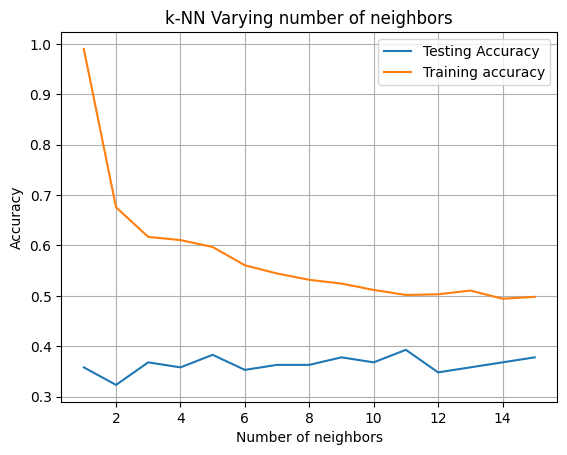

In [151]:
# Inspect for optimal K
plt.figure()
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.grid()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We choose k=11 which has the highest accuracy on testing data

In [152]:
# Accuracy of test data when K=11
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(train_features, train_label)
print(f'Accuracy on test data = {knn.score(test_features, test_label)}')

Accuracy on test data = 0.39303482587064675


### 4.2.2. Evaluation

In [153]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

              precision    recall  f1-score   support

         0.0       0.43      0.54      0.48       155
         1.0       0.46      0.67      0.55       160
         2.0       0.46      0.37      0.41       163
         3.0       0.64      0.66      0.65       155
         4.0       0.58      0.30      0.39       166

    accuracy                           0.50       799
   macro avg       0.51      0.51      0.49       799
weighted avg       0.51      0.50      0.49       799



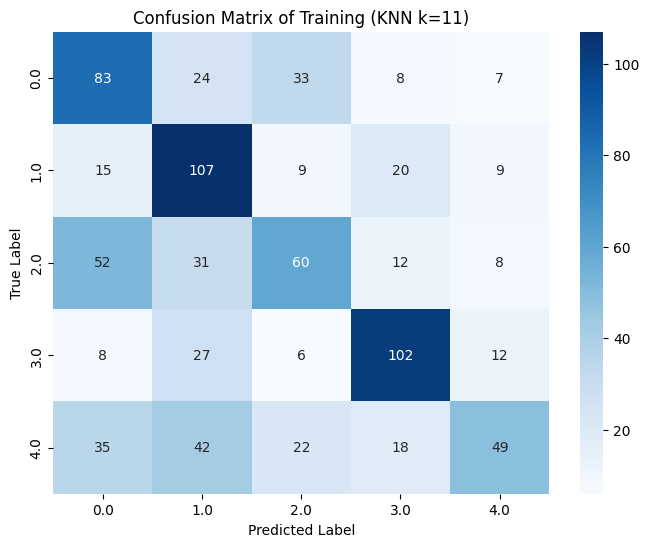

In [154]:
# Get the predictions using the classifier with k=11
train_label_pred = knn.predict(train_features)

# Metrics
print(classification_report(train_label, train_label_pred))

# Compute confusion matrix with sklearn.metrics
conf_matrix = confusion_matrix(train_label, train_label_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Training (KNN k=11)")
plt.show()

              precision    recall  f1-score   support

         0.0       0.44      0.38      0.40        45
         1.0       0.34      0.53      0.41        40
         2.0       0.40      0.27      0.32        37
         3.0       0.55      0.62      0.58        45
         4.0       0.12      0.09      0.10        34

    accuracy                           0.39       201
   macro avg       0.37      0.38      0.37       201
weighted avg       0.38      0.39      0.38       201



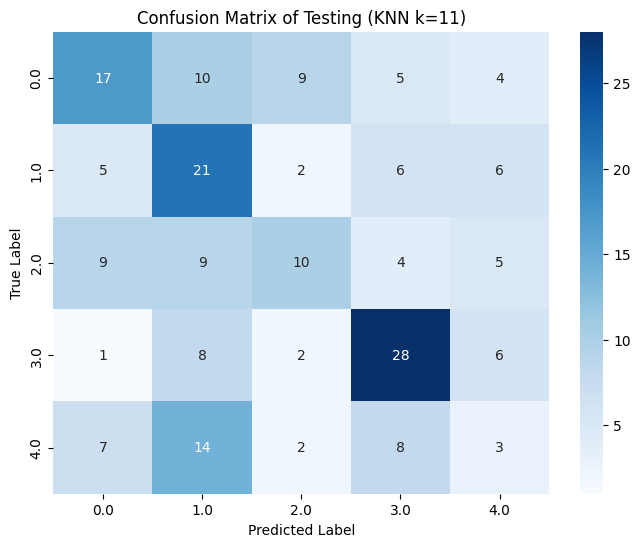

In [155]:
# Get the predictions using the classifier with k=11
test_label_pred = knn.predict(test_features)

# Metrics
print(classification_report(test_label, test_label_pred))

# Compute confusion matrix with sklearn.metrics
conf_matrix = confusion_matrix(test_label, test_label_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Testing (KNN k=11)")
plt.show()

In [156]:
# Find ROC Curve (only able to run for each class)

## 4.3. Decision Tree Classification

In [157]:
from pyspark.ml.classification import DecisionTreeClassifier

### 4.3.1. Training

In [158]:
# Extract only label and normFeatures for modeling
train_dt = train.select('label', 'normFeatures')
train_dt.show(5, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------+
|label|normFeatures                                                                                                   |
+-----+---------------------------------------------------------------------------------------------------------------+
|2.0  |[20.073058948592916,5.142573500734494,11.988341336913885,2.026185505971019,0.0,2.3186762623372807]             |
|2.0  |[20.122301460263987,0.0,11.988341336913885,2.5890148131851913,0.0,2.5405495007217174]                          |
|4.0  |[18.61256174092945,5.142573500734494,11.988341336913885,3.9398051504992044,2.311336097935122,3.276679443072142]|
|0.0  |[20.462273202798233,5.142573500734494,0.0,3.1518441203993635,0.0,1.7456342094935284]                           |
|2.0  |[19.40101699941208,5.142573500734494,11.988341336913885,0.39398051504992043,0.0,3.2268769959165158]            |
+-----+---------------------------------

In [159]:
# Extract only label and normFeatures for testing
test_dt = test.select('label', 'normFeatures')
test_dt.show(5, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------+
|label|normFeatures                                                                                                  |
+-----+--------------------------------------------------------------------------------------------------------------+
|3.0  |[20.538743334525186,0.0,11.988341336913885,3.6583904968921184,0.0,3.4356417639850614]                         |
|2.0  |[19.697725015334317,5.142573500734494,11.988341336913885,1.9699025752496022,0.0,3.179953199954028]            |
|0.0  |[19.99386421339271,5.142573500734494,11.988341336913885,2.476448951742357,0.0,3.077685467633787]              |
|0.0  |[19.896950695925412,5.142573500734494,11.988341336913885,3.4895417047278667,0.0,3.4905704336497334]           |
|1.0  |[18.784218699569156,5.142573500734494,11.988341336913885,2.3076001595781053,2.311336097935122,3.4627383265225]|
+-----+-----------------------------------------

In [160]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="label", featuresCol="normFeatures")
dt_model = dt.fit(train_dt)

### 4.3.2. Summary of Model

In [161]:
print(dt_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_312d8f7dd6e7, depth=5, numNodes=57, numClasses=5, numFeatures=6
  If (feature 5 <= 3.4030837494314574)
   If (feature 5 <= 2.884962824326511)
    If (feature 3 <= 1.1538000797890526)
     If (feature 5 <= 1.5746415638399616)
      If (feature 0 <= 17.259849259915526)
       Predict: 1.0
      Else (feature 0 > 17.259849259915526)
       Predict: 2.0
     Else (feature 5 > 1.5746415638399616)
      If (feature 0 <= 19.875848264856685)
       Predict: 1.0
      Else (feature 0 > 19.875848264856685)
       Predict: 0.0
    Else (feature 3 > 1.1538000797890526)
     If (feature 3 <= 2.8985709321529862)
      If (feature 0 <= 19.372880431704363)
       Predict: 2.0
      Else (feature 0 > 19.372880431704363)
       Predict: 0.0
     Else (feature 3 > 2.8985709321529862)
      If (feature 0 <= 20.335989661339198)
       Predict: 4.0
      Else (feature 0 > 20.335989661339198)
       Predict: 0.0
   Else (feature 5 > 2.88496282432651

### 4.3.3. Prediction

In [162]:
# Predictions on training set
pred_train_dt = dt_model.transform(train_dt)
pred_train_dt.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|        normFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  2.0|[20.0730589485929...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  2.0|[20.1223014602639...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  4.0|[18.6125617409294...|[4.0,3.0,4.0,5.0,...|[0.09756097560975...|       4.0|
|  0.0|[20.4622732027982...|[8.0,0.0,3.0,0.0,...|[0.66666666666666...|       0.0|
|  2.0|[19.4010169994120...|[6.0,13.0,3.0,5.0...|[0.13043478260869...|       4.0|
|  2.0|[19.9776347584197...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  0.0|[19.7070426989255...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  2.0|[20.0922846119828...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  2.0|[21.0970842299653...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  4.0|[18.83558

In [163]:
# Predictions on testing set
pred_test_dt = dt_model.transform(test_dt)
pred_test_dt.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|        normFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  3.0|[20.5387433345251...|[4.0,6.0,6.0,23.0...|[0.09523809523809...|       3.0|
|  2.0|[19.6977250153343...|[12.0,62.0,15.0,7...|[0.10810810810810...|       1.0|
|  0.0|[19.9938642133927...|[1.0,0.0,6.0,0.0,...|[0.11111111111111...|       2.0|
|  0.0|[19.8969506959254...|[4.0,6.0,6.0,23.0...|[0.09523809523809...|       3.0|
|  1.0|[18.7842186995691...|[0.0,0.0,0.0,3.0,...|[0.0,0.0,0.0,0.33...|       4.0|
|  0.0|[19.9924675854726...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  0.0|[20.1837493546207...|[67.0,11.0,62.0,0...|[0.42405063291139...|       0.0|
|  1.0|[18.4719665568093...|[12.0,62.0,15.0,7...|[0.10810810810810...|       1.0|
|  0.0|[19.5799346419572...|[12.0,62.0,15.0,7...|[0.10810810810810...|       1.0|
|  0.0|[20.02694

### 4.3.4. Evaluation

In [164]:
# Evaluator
evaluator = MulticlassClassificationEvaluator()

training data (f1): 0.5312382964652973 
 training data (weightedPrecision):  0.5397930685246455 
 training data (weightedRecall):  0.5294117647058824 
 training data (accuracy):  0.5294117647058824


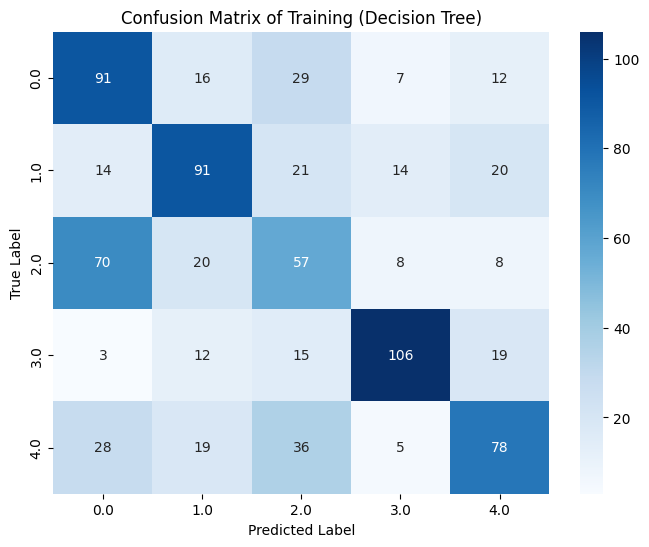

In [165]:
# Prediction accuracy on training data
print('training data (f1):', evaluator.setMetricName('f1').evaluate(pred_train_dt), "\n",
     'training data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_train_dt),"\n",
     'training data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_train_dt),"\n",
     'training data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_train_dt))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_train_dt.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Training (Decision Tree)")
plt.show()

testing data (f1): 0.41121793754760905 
 testing data (weightedPrecision):  0.4139536499865415 
 testing data (weightedRecall):  0.4129353233830846 
 testing data (accuracy):  0.4129353233830846


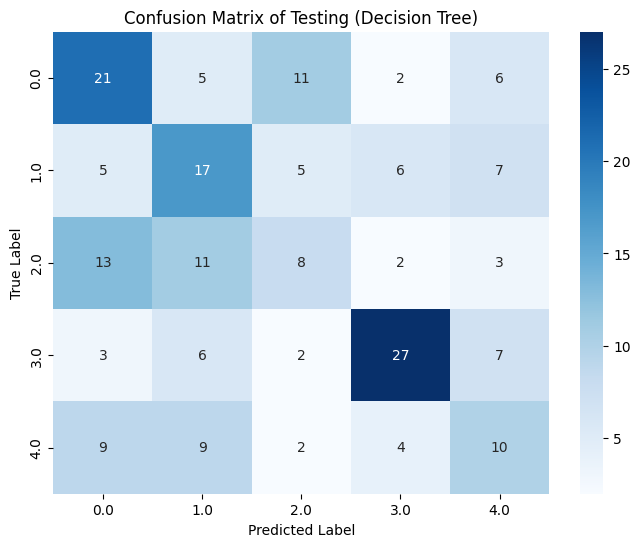

In [166]:
# Prediction accuracy on testing data
print('testing data (f1):', evaluator.setMetricName('f1').evaluate(pred_test_dt), "\n",
     'testing data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_test_dt),"\n",
     'testing data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_test_dt),"\n",
     'testing data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_test_dt))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_test_dt.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Testing (Decision Tree)")
plt.show()

## 4.4. Random Forest

### 4.4.1. Training

In [167]:
from pyspark.ml.classification import RandomForestClassifier

In [168]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="normFeatures", numTrees=10)
rf_model = rf.fit(train_dt)

### 4.4.2. Summary of Model

In [169]:
print(rf_model.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_4f8a706bdc78, numTrees=10, numClasses=5, numFeatures=6
  Tree 0 (weight 1.0):
    If (feature 0 <= 19.560224682788785)
     If (feature 5 <= 3.54563957710653)
      If (feature 0 <= 17.259849259915526)
       If (feature 3 <= 1.772912317724642)
        If (feature 5 <= 2.799358333624873)
         Predict: 1.0
        Else (feature 5 > 2.799358333624873)
         Predict: 2.0
       Else (feature 3 > 1.772912317724642)
        Predict: 3.0
      Else (feature 0 > 17.259849259915526)
       If (feature 3 <= 2.8985709321529862)
        If (feature 5 <= 2.884962824326511)
         Predict: 2.0
        Else (feature 5 > 2.884962824326511)
         Predict: 1.0
       Else (feature 3 > 2.8985709321529862)
        Predict: 4.0
     Else (feature 5 > 3.54563957710653)
      If (feature 3 <= 0.028141465360708603)
       Predict: 4.0
      Else (feature 3 > 0.028141465360708603)
       If (feature 5 <= 3.6204913807997094)
        If (fe

### 4.4.3. Prediction

In [170]:
# Predictions on training set
pred_train_rf = rf_model.transform(train_dt)
pred_train_rf.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|        normFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  2.0|[20.0730589485929...|[3.80719121832451...|[0.38071912183245...|       2.0|
|  2.0|[20.1223014602639...|[4.37758711004606...|[0.43775871100460...|       0.0|
|  4.0|[18.6125617409294...|[0.27382697947214...|[0.02738269794721...|       4.0|
|  0.0|[20.4622732027982...|[5.03520109889260...|[0.50352010988926...|       0.0|
|  2.0|[19.4010169994120...|[1.63889069610551...|[0.16388906961055...|       1.0|
|  2.0|[19.9776347584197...|[4.74821357661096...|[0.47482135766109...|       0.0|
|  0.0|[19.7070426989255...|[3.79887689324315...|[0.37988768932431...|       0.0|
|  2.0|[20.0922846119828...|[3.39795878717541...|[0.33979587871754...|       2.0|
|  2.0|[21.0970842299653...|[2.76483638623659...|[0.27648363862365...|       2.0|
|  4.0|[18.83558

In [171]:
# Predictions on testing set
pred_test_rf = rf_model.transform(test_dt)
pred_test_rf.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|        normFeatures|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  3.0|[20.5387433345251...|[1.17986896615928...|[0.11798689661592...|       3.0|
|  2.0|[19.6977250153343...|[1.15879622880795...|[0.11587962288079...|       1.0|
|  0.0|[19.9938642133927...|[2.64121579803565...|[0.26412157980356...|       2.0|
|  0.0|[19.8969506959254...|[0.71745637874670...|[0.07174563787467...|       3.0|
|  1.0|[18.7842186995691...|[1.31955558428161...|[0.13195555842816...|       3.0|
|  0.0|[19.9924675854726...|[3.80719121832451...|[0.38071912183245...|       2.0|
|  0.0|[20.1837493546207...|[5.25801749817959...|[0.52580174981795...|       0.0|
|  1.0|[18.4719665568093...|[1.68658864270797...|[0.16865886427079...|       1.0|
|  0.0|[19.5799346419572...|[2.40378396698956...|[0.24037839669895...|       1.0|
|  0.0|[20.02694

### 4.4.4. Evaluation

In [172]:
# Evaluator
evaluator = MulticlassClassificationEvaluator()

training data (f1): 0.5543386610101456 
 training data (weightedPrecision):  0.5667302825831679 
 training data (weightedRecall):  0.5544430538172715 
 training data (accuracy):  0.5544430538172715


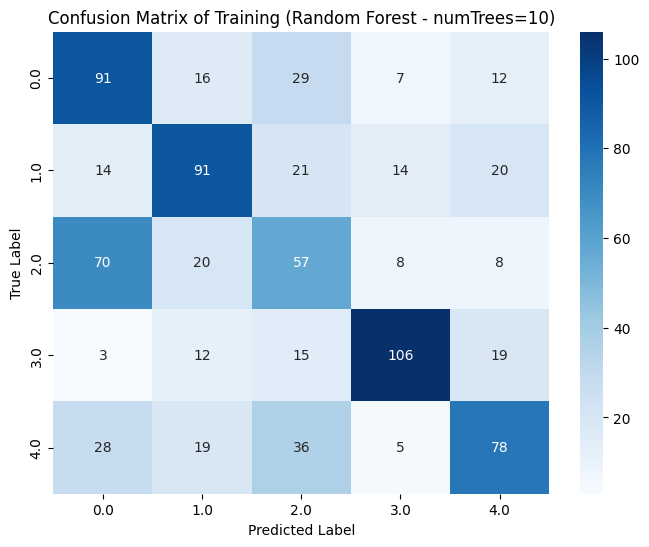

In [173]:
# Prediction accuracy on training data
print('training data (f1):', evaluator.setMetricName('f1').evaluate(pred_train_rf), "\n",
     'training data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_train_rf),"\n",
     'training data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_train_rf),"\n",
     'training data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_train_rf))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_train_dt.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Training (Random Forest - numTrees=10)")
plt.show()

testing data (f1): 0.397045515775005 
 testing data (weightedPrecision):  0.4095453238459811 
 testing data (weightedRecall):  0.3980099502487562 
 testing data (accuracy):  0.39800995024875624


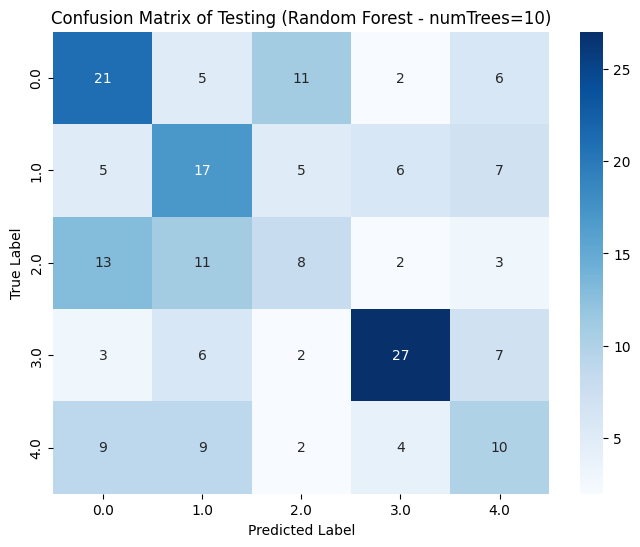

In [174]:
# Prediction accuracy on testing data
print('testing data (f1):', evaluator.setMetricName('f1').evaluate(pred_test_rf), "\n",
     'testing data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(pred_test_rf),"\n",
     'testing data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(pred_test_rf),"\n",
     'testing data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(pred_test_rf))

# Collect data to driver as a Pandas DataFrame
pandas_df = pred_test_dt.toPandas()

# Compute confusion matrix
conf_matrix = confusion_matrix(pandas_df['label'], pandas_df['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
range_label = [0.0, 1.0, 2.0, 3.0, 4.0]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range_label, yticklabels=range_label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Testing (Random Forest - numTrees=10)")
plt.show()